In [74]:
import pandas as pd
import requests
import urllib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import requests
from urllib.parse import urlencode

In [75]:
# Font size will be increased, background of figures will be white, grid will be present and size of plots will be increased

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

# Задание 1
## Реализовать функцию для рассчета retantion

In [76]:
reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')

In [77]:
def retention_by_day(df_reg, df_aut):
    df_reg = df_reg.drop_duplicates()
    df_aut = df_aut.drop_duplicates()
    """ дропаем дубликаты"""
    
    def delta_time(x, y):
        a = abs(x-y)
        days_from_reg = (a/86400).round(0)
        """ функция возвращает разницу в днях от даты регистрации до даты входа в приложение, float """
        return days_from_reg
    
    all_data = df_reg.merge(df_aut, on = 'uid')
    
    all_data = all_data.dropna()
    """удаляем пустые значения"""
    
    
    all_data['delta_time_from_reg'] = delta_time(all_data.auth_ts.values, all_data.reg_ts.values)
    all_data['delta_time_from_reg'] = all_data['delta_time_from_reg'].apply(lambda x: int(x))
    all_data['registrer_date'] = pd.to_datetime(all_data.reg_ts.values, unit='s')
    all_data['autentific_date'] = pd.to_datetime(all_data.auth_ts.values, unit='s')
    all_data['registrer_date'] = all_data['registrer_date'].dt.date
    all_data['autentific_date'] = all_data['autentific_date'].dt.date
    all_data = all_data.groupby(["delta_time_from_reg", "registrer_date"], as_index=False).agg({"uid": "nunique"})
    retention = all_data.pivot(index = 'registrer_date', columns = 'delta_time_from_reg', values = 'uid')
    base = retention[0]
    retention = retention.divide(base, axis=0).round(3)
    return retention

In [78]:
rrr = retention_by_day(reg_data, auth_data)
rrr

delta_time_from_reg,0,1,2,3,4,5,6,7,8,9,...,7700,7704,7706,7709,7712,7716,7719,7720,7726,7729
registrer_date,,,,,,,,,,,,,,,,,,,,,
1998-11-18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-22,1.0,NaN,NaN,1.000,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-13,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-28,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-16,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,1.0,0.018,0.037,0.045,0.034,0.001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-20,1.0,0.023,0.042,0.026,0.001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-21,1.0,0.020,0.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Реализована функция рассчета retention, на вход подается датафрейм структуры "время регистрации, айди пользователя" и датафрем структуры "время входа, айди пользователя"
## Функция возвращает таблицу retention где колонки (когорты) - время между регистрацией и входом в днях, индексы - дата регистрации, значение - количество юзеров в когорте

# Задание 2
## Проанализировать результаты АВ-теста

In [79]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'  # ссылка для скачивания

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('Проект_1_Задание_2.csv', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

df = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [80]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [81]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [82]:
df.query('revenue < 0').value_counts() # проверка на отрицательную сумму покупки

Series([], dtype: int64)

In [83]:
df.isna().value_counts() #проверка на пустые значения

user_id  revenue  testgroup
False    False    False        404770
dtype: int64

In [84]:
control_group = df.query('testgroup == "a"')
test_group = df.query('testgroup == "b"')

In [85]:
control_group = control_group.drop_duplicates() # скидывае дубликаты
test_group = test_group.drop_duplicates()

In [86]:
control_group.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [87]:
test_group.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


## 1. Конверсия
### Проверим различие конверсии используя Хи-квадрат, так как метрики доходов зависят от конверсии. Далее можно провеить различие в среднем чеке, и повторные покупки.

In [88]:
dfchi = df
dfchi['purchase'] = dfchi.revenue.apply(lambda x: 1 if x!=0 else 0)
#создаю колонку куда записываю 1 если покупка была совершена, 0 - если нет

In [89]:
import pingouin as pg

In [90]:
expected, observed, stats = pg.chi2_independence(dfchi, x='purchase', y='testgroup') #счиатем хи-квадрат

In [91]:
expected

testgroup,a,b
purchase,,
0,200239.100751,200797.899249
1,1863.899249,1869.100751


In [92]:
observed

testgroup,a,b
purchase,,
0,200175.5,200861.5
1,1927.5,1805.5


In [93]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4.374730,1.0,0.036476,0.003288,0.552384
1,cressie-read,0.666667,4.374870,1.0,0.036473,0.003288,0.552397
2,log-likelihood,0.000000,4.375431,1.0,0.036461,0.003288,0.552450
3,freeman-tukey,-0.500000,4.376097,1.0,0.036446,0.003288,0.552513
4,mod-log-likelihood,-1.000000,4.376973,1.0,0.036428,0.003288,0.552596
5,neyman,-2.000000,4.379356,1.0,0.036377,0.003289,0.552821


### В результате проведенного статистического теста p-value < 0.05, что позволяет нам отклонить нулевую гипотезу об отсутсвии различий конверсии между группами. Конверсия в контрольной группе статистически значимо различается по сравнению с тестовой группой (в контрольной группе конверсия больше).

## ARPPU

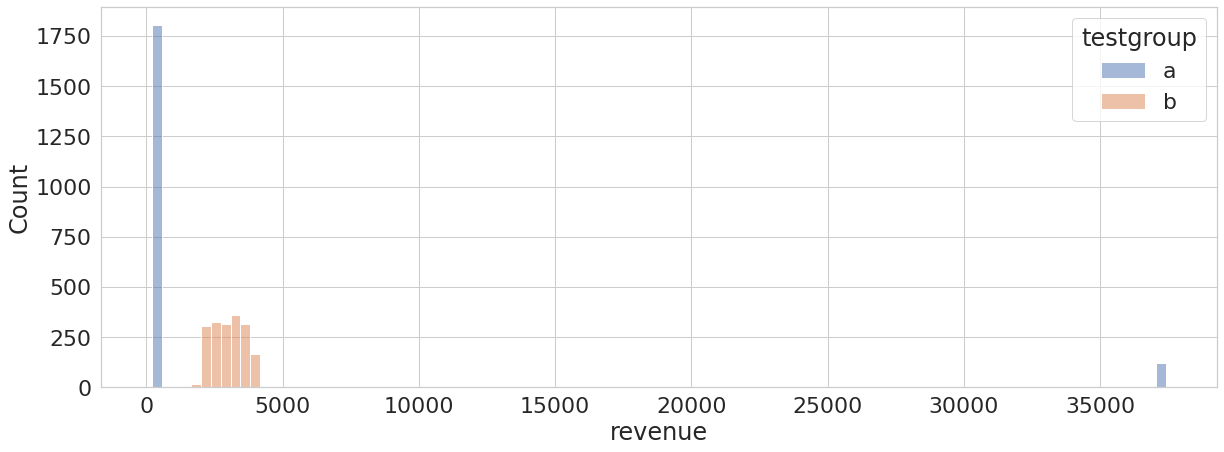

In [94]:
sns.histplot(data=dfchi[(dfchi['purchase'] == True)], x='revenue', hue='testgroup')

### Построив график распределния покупок в двух группах видно, что в контрольной группе есть явный выброс.

### В данном случае повторных покупок в обеих группах клиенты не совершали, то ARPPU численно равна среднему чеку. Проведем сравнение среднего чека в группах, предварительно избавившись от явного выброса в контрольной группе.

In [95]:
group_1 = control_group.query('revenue < 5000').revenue
group_2 = test_group.query('revenue < 5000').revenue
ss.ttest_ind(a=group_1, b=group_2, equal_var=True)

Ttest_indResult(statistic=-37.42623596967759, pvalue=4.912187544972622e-306)

## ARPU

In [96]:
df_arpu = dfchi.query('revenue < 5000') #отобрал значения и избавился от выбросов

In [97]:
#проверка на то что все пользователи совершили по 1 покупке
df_arpu.user_id.nunique() == len(df_arpu.user_id)


True

In [98]:
df_arpu_contr = df_arpu.query('testgroup == "a"')
df_arpu_test = df_arpu.query('testgroup == "b"')

In [99]:
clients_contr = len(df_arpu_contr[df_arpu_contr.purchase == 1])
clients_test = len(df_arpu_test[df_arpu_test.purchase == 1])


In [100]:
# вычисляю ARPU для юзеров в двух группах
df_arpu_contr['arpu'] = df_arpu_contr['revenue'].apply(lambda x: (x/clients_contr)) 
df_arpu_test['arpu'] = df_arpu_test['revenue'].apply(lambda x: (x/clients_test))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
# H0: Дисперсии во всех группах равны (гомогенны)
# H1: Дисперсии в каких-то группах отличаются (гетерогенны)

group1 = df_arpu_contr.query('purchase == 1').arpu
group2 = df_arpu_test.query('purchase == 1').arpu

statistics, p_value = ss.ttest_ind(a=group1, b=group2)
alpha =0.05
if p_value < alpha:
    print("Существует статистически значимое различие между средними значениями ARPU в двух группах")
else:
    print("Нет статистически значимого различия между средними значениями ARPU в двух группах")

Существует статистически значимое различие между средними значениями ARPU в двух группах


В результате проведенного t-теста мы отклоняем нулевую гипотезу, следовательно среднее ARPU значимо различается в двух группах, в пользу тестовой ("b") группы.

# ИТОГ
### Для оценки результатов и формулировки выводов проведенного АВ теста, контрольная и тестовая группы сравнивались по метрикам конверсии в покупку (CR), ARPPU, ARPU.

### 1. CR в двух группах статистически различается, а значит что акция в первой группе лучше заходили людям, так как заказов в тестовой группе меньше, чем в контрольной. p value <0,05
### 2. Повторных покупок не было ни в одной группе, а это значит что ARPPU численно равен среднему чеку. В результате сравнения среднего чека в двух группах было выявлено их статистическое различие в пользу тестовой группы, средний чек в ней гораздо выше чем в контрольной.
### 3. ARPU значимо различается межлу группами, опять же в пользу тестовой группы. Из этого следует что пользователи группы b принесли больше дохода компании, чем контрольная группа.
## Вывод - конверсия в покупку была лучше у контрольной группы, но больший доход принесла тестовая группа.

### Исходя из представленных выше выводов появились сомнения в корректности проведенного эксперимента - т.к. в группах разные, непересекающиеся сегменты пользователей по величине оплат, то наиболее вероятно, что дизайн эксперимента нарушен и сплитование проведено некорректно. 

# Задание 3
## Предложить метрики для оценки результатов последнего прошедшего тематического события в игре.

 В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Метрики, которыми можно оценить результаты события:
### 1. Отношение времени затраченного игроком в тематическом событии к общему времени проведенному в  игре.  (показывает интерес пользователя к новому режиму)
### 2. Среднее количество уровней пройденных игроками (показатель вовлеченности игроков)
### 3. Отношение игроков прошедших 50% всеX уровней события ко всем игрокам которые пробовали событие. (трудность/интересность уровней) 
### 4. Отношение среднего онлайна игры во время события к среднему онлайну до события.
### 5. Отток игроков из игры после события.
### 6. Конверсия в покупку до ивента/после ивента.
### 7. ARPU

### Для данного набора метрик усложнение механики события не скажется на их выборе, потому что усложнение процесса прохождения уровней события будет отражаться на времени игроков проведенном в игре, а все вышеописанные метрики направлены на изерение времени проведенного в игре, анализ предложенных метрик позволит сделать выводы об успешности события и на сколько оно нравится аудитории в режиме реального времени. Метрики продаж (конверсия и ARPU) покажут - был ли ивент успешен финансово. 